<a href="https://colab.research.google.com/github/Rafagars/Modern-Portfolio-Theory/blob/main/Proyecto2_CO5516_Rafael_Garcia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Proyecto II CO5516 Matematicas Financieras II: Selección de Portafolios Óptimos para Diferentes Perfiles de Inversores

## Resumen

Este proyecto integra la teoría de utilidad con la optimización de portafolios para construir carteras óptimas
personalizadas para inversores con distintos niveles de aversión al riesgo. Utilizando los diez activos principales
del S&P 500 analizados en el Proyecto I, se definen tres perfiles de inversores hipotéticos, cada uno
caracterizado por una función de utilidad diferente: cuadrática, logarítmica y potencial con aversión al riesgo
relativa. Para cada perfil, se derivan numéricamente las curvas de indiferencia y se optimiza la asignación de
activos maximizando la utilidad esperada. Los resultados muestran cómo las preferencias de riesgo impactan
significativamente la composición y ubicación de los portafolios óptimos en el espacio riesgo-retorno, con
diferencias notables en la exposición a activos defensivos versus agresivos.

## Abstract

This project integrates utility theory with portfolio optimization to build customized optimal portfolios for
investors with different risk aversion levels. Using the ten main S&P 500 assets analyzed in Project I, three
hypothetical investor profiles are defined, each characterized by a different utility function: quadratic,
logarithmic, and power utility with relative risk aversion. For each profile, indifference curves are numerically
derived and asset allocations are optimized to maximize expected utility. The results demonstrate how risk
preferences significantly impact the composition and location of optimal portfolios in the risk-return space, with
notable differences in exposure to defensive versus aggressive assets.

In [ ]:
!pip install yfinance
!pip install pyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 8.9 MB/s eta 0:00:00


In [ ]:
#@title Cargamos las librerias
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

In [ ]:
import pypfopt
from pypfopt import risk_models
from pypfopt import plotting
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions

# 1. Cargar y preparar datos

In [ ]:
fecha_inicio = dt.datetime(2020, 6, 1)
fecha_final = dt.datetime(2025, 5, 31)

lista_activos = ['MSFT', 'NVDA', 'AAPL', 'AMZN', 'META', 'AVGO', 'GOOGL', 'TSLA', 'BRK-B', 'GOOG'] #Tomamos las 10 acciones mas influyentes del S&P500
portfolio = yf.download(lista_activos, start=fecha_inicio, end=fecha_final) #Descargamos la informacion de los ultimos 5 años

/tmp/ipython-input-8-2280938440.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  portfolio = yf.download(lista_activos, start=fecha_inicio, end=fecha_final) #Descargamos la informacion de los ultimos 5 años
[*********************100%***********************]  10 of 10 completed


In [ ]:
portfolio = portfolio['Close'].dropna() #Eliminamos los valores nulos

In [ ]:
portfolio.head()

Ticker,AAPL,AMZN,AVGO,BRK-B,GOOG,GOOGL,META,MSFT,NVDA,TSLA
Date,,,,,,,,,,
2020-06-01,78.215126,123.552002,25.464319,183.839996,71.167976,71.315796,230.644653,175.166809,8.773314,59.873333
2020-06-02,78.577194,123.620499,26.172951,185.940002,71.535782,71.685577,231.450256,177.159622,8.792246,58.770668
2020-06-03,79.009796,123.919998,27.180143,190.820007,71.394623,71.533485,228.904221,177.590729,8.736703,58.863998
2020-06-04,78.329338,123.029999,27.123940,192.050003,70.191772,70.293427,225.055313,175.253006,8.737699,57.625332
2020-06-05,80.560219,124.150002,27.843113,200.660004,71.494522,71.571754,229.510910,179.353607,8.890697,59.043999


In [ ]:
portfolio.to_csv('portfolio.csv', index=True) #Convertimos a archivo csv nuestra data descargada
portfolio = pd.read_csv('portfolio.csv', index_col="Date", parse_dates=True) #La cargamos ahora como un dataframe usando pandas

In [ ]:
#@title Calculamos los rendimientos logaritmicos
rendimientos_log = np.log(portfolio).diff()
rendimientos_log.dropna(inplace=True)

In [ ]:
#@title  Rendimiento anual esperado de cada accion
mu = expected_returns.mean_historical_return(portfolio, frequency=252, compounding=False, log_returns=True)
mu

,0
AAPL,0.189220
AMZN,0.101602
AVGO,0.451352
BRK-B,0.202329
GOOG,0.177800
GOOGL,0.176090
META,0.206948
MSFT,0.193869
NVDA,0.548632
TSLA,0.352225


<Axes: title={'center': 'Rendimiento anual esperado de los activos'}>

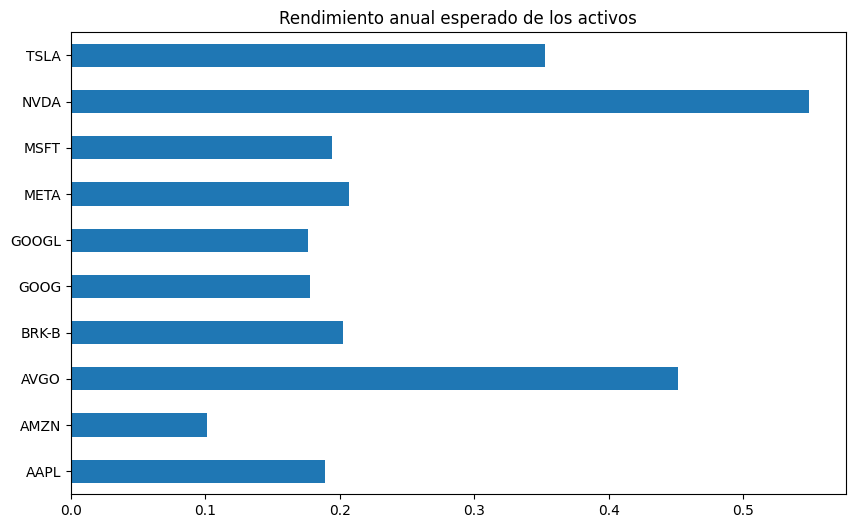

In [ ]:
#@title Grafico de barra del Rendimiento anual esperado de los activos
mu.plot.barh(figsize=(10,6), title='Rendimiento anual esperado de los activos')

In [ ]:
#@title Matriz de Varianza - Covarianza
S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()
S

,AAPL,AMZN,AVGO,BRK-B,GOOG,GOOGL,META,MSFT,NVDA,TSLA
AAPL,0.090924,0.063522,0.060787,0.022939,0.053758,0.054015,0.069140,0.054170,0.085963,0.095766
AMZN,0.063522,0.127961,0.072694,0.021286,0.071399,0.071186,0.097795,0.066272,0.108653,0.105031
AVGO,0.060787,0.072694,0.165366,0.020859,0.059190,0.059841,0.078763,0.059894,0.141624,0.113639
BRK-B,0.022939,0.021286,0.020859,0.034678,0.021520,0.021294,0.023967,0.018438,0.025088,0.027849
GOOG,0.053758,0.071399,0.059190,0.021520,0.096936,0.095157,0.082375,0.057697,0.089511,0.081629
GOOGL,0.054015,0.071186,0.059841,0.021294,0.095157,0.097393,0.082464,0.057977,0.089938,0.081622
META,0.069140,0.097795,0.078763,0.023967,0.082375,0.082464,0.194144,0.070565,0.118983,0.097711
MSFT,0.054170,0.066272,0.059894,0.018438,0.057697,0.057977,0.070565,0.074494,0.092022,0.077487
NVDA,0.085963,0.108653,0.141624,0.025088,0.089511,0.089938,0.118983,0.092022,0.279738,0.160958
TSLA,0.095766,0.105031,0.113639,0.027849,0.081629,0.081622,0.097711,0.077487,0.160958,0.408371


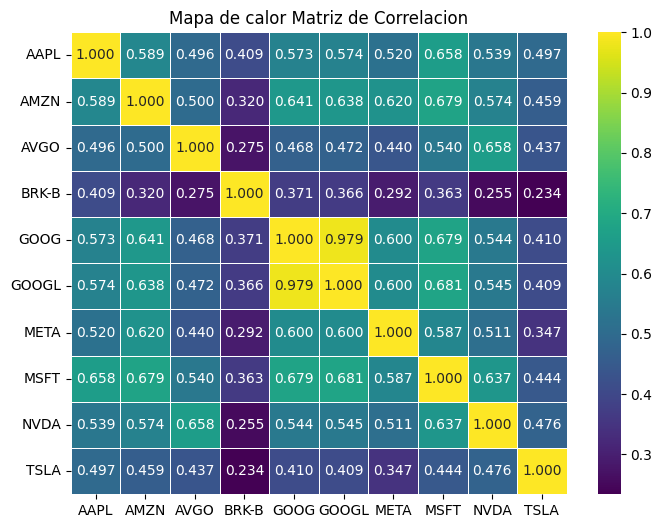

In [ ]:
# @title Mapa de Calor de Matriz de Correlaccion
plt.figure(figsize=(8, 6))
sns.heatmap(
  risk_models.cov_to_corr(S),
  annot=True, #Muestra los valores de la correlacion
  cmap='viridis',
  fmt=".3f",        # Format the annotation values
  linewidths=.5
)
plt.title('Mapa de calor Matriz de Correlacion')
plt.show()

In [ ]:
# @title Riesgo anual
riesgo_anual = rendimientos_log.std() * np.sqrt(252) #Riesgo anual que es lo mismo que la desviacion estandar anual
riesgo_anual #Podemos ver que coincide con la raiz de cada una de las varianzas de la ma

,0
AAPL,0.299609
AMZN,0.357168
AVGO,0.403000
BRK-B,0.182963
GOOG,0.310662
GOOGL,0.311347
META,0.445435
MSFT,0.271241
NVDA,0.526477
TSLA,0.638103


In [ ]:
#@title Tasa libre de riesgo (Utilizamos los fondos del Tesoro de los EEUU como proxy)

rf = 0.044

# 2. Calcular la Frontera Eficiente

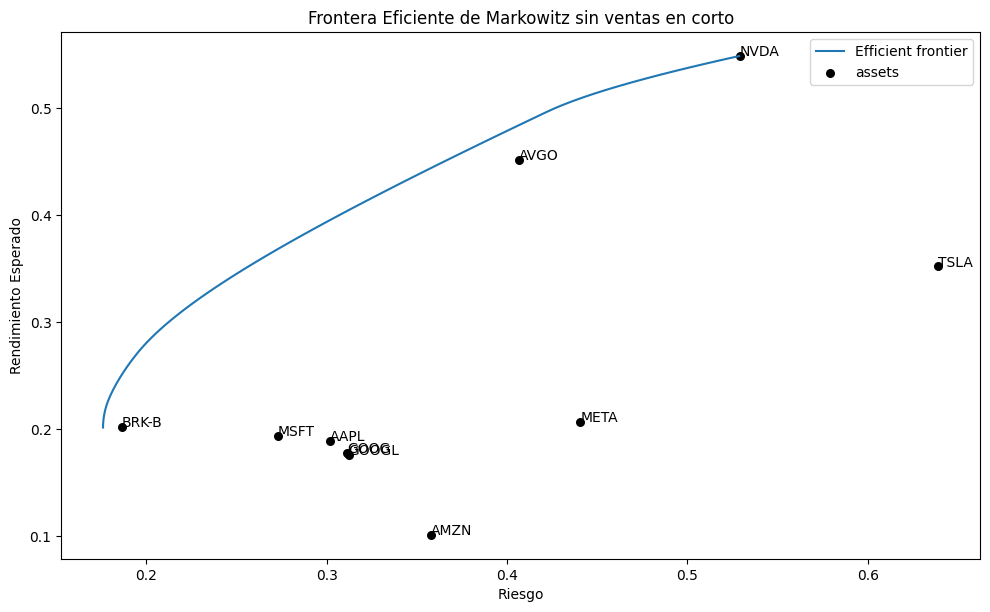

In [ ]:
# @title Grafico de Frontera Eficiente sin ventas en corto
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))

fig, ax = plt.subplots(figsize= (10,6))
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True, show_tickers=True)
plt.xlabel('Riesgo')
plt.ylabel('Rendimiento Esperado')
plt.title('Frontera Eficiente de Markowitz sin ventas en corto')
plt.show()

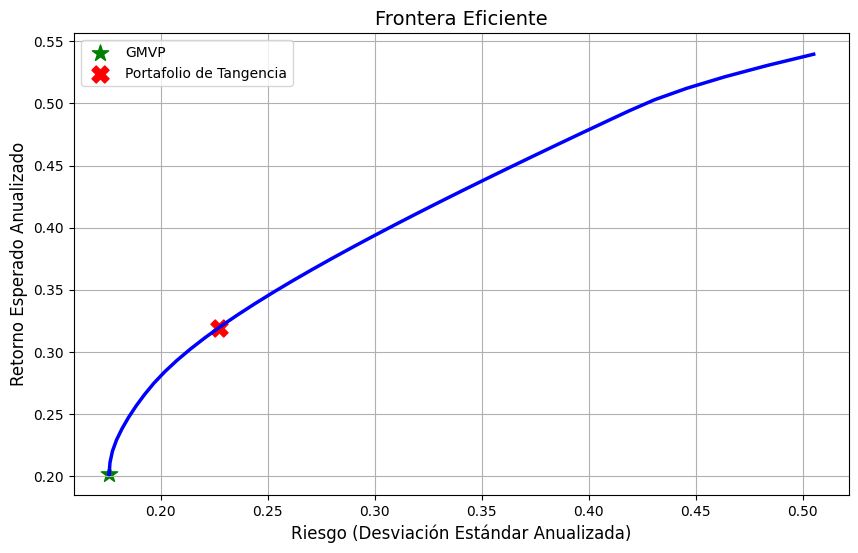

In [ ]:
# Crear frontera eficiente
ef = EfficientFrontier(mu, S)

# Calcular puntos para la frontera
n_points = 50
target_returns = np.linspace(mu.min(), mu.max(), n_points)
efficient_portfolios = []

for target_return in target_returns:
    try:
        ef.efficient_return(target_return=target_return)
        weights = ef.clean_weights()
        ret, vol, _ = ef.portfolio_performance(verbose=False)
        efficient_portfolios.append((ret, vol, weights))
    except:
        continue

# Convertir a DataFrame
efficient_df = pd.DataFrame(efficient_portfolios, columns=['Retorno', 'Riesgo', 'Pesos'])

fig, ax = plt.subplots(figsize=(10,6))
# Buscamos y graficamos la Minima Varianza
ef2 = EfficientFrontier(mu, S, weight_bounds=(0, 1))
ef2.min_volatility()
ret_min, std_min, _ = ef2.portfolio_performance()

# Buscamos y graficamos el punto Tangente
ef3 = EfficientFrontier(mu, S, weight_bounds=(0, 1))
ef3.max_sharpe(risk_free_rate=rf)
ret_tangent, std_tangent, _ = ef3.portfolio_performance(risk_free_rate=rf)

ax.scatter(std_min, ret_min, c='green', marker='*',s=150, label= 'GMVP')
ax.scatter(std_tangent, ret_tangent, c='red', marker='X',s=150, label= 'Portafolio de Tangencia')


# Graficar frontera eficiente

ax.plot(efficient_df['Riesgo'], efficient_df['Retorno'], 'b-', linewidth=2.5)
ax.set_title('Frontera Eficiente', fontsize=14)
ax.set_xlabel('Riesgo (Desviación Estándar Anualizada)', fontsize=12)
ax.set_ylabel('Retorno Esperado Anualizado', fontsize=12)
ax.grid(True)
plt.legend()


# 3. Definir perfiles de inversores

In [ ]:
# Perfil 1: Utilidad cuadrática (aversión constante al riesgo)
def utilidad_cuadratica(retorno, riesgo, A):
    """U = E[R] - 0.5 * A * Var(R)"""
    return retorno - 0.5 * A * (riesgo**2)

# Perfil 2: Utilidad logarítmica (aversión relativa al riesgo constante)
def utilidad_logaritmica(retorno, riesgo, gamma):
    """U = log(1 + E[R]) - 0.5 * gamma * (Var(R)/(1 + E[R])^2)"""
    return np.log(1 + retorno) - 0.5 * gamma * (riesgo**2 / (1 + retorno)**2)

def utilidad_exponencial(retorno, riesgo, gamma):
    return -np.exp((-gamma * retorno) + (0.5 * gamma**2 * riesgo**2))

# Parámetros de aversión al riesgo
A1 = 6      # Alto nivel de aversión (conservador)
gamma2 = 5  # Aversión moderada
gamma3 = 1  # Aversión baja (agresivo)


# 4. Encontrar portafolios óptimos


In [ ]:
def encontrar_optimo(funcion_util, parametro):
    """Encuentra el portafolio óptimo en la frontera eficiente"""
    utilidades = []
    for _, row in efficient_df.iterrows():
        util = funcion_util(row['Retorno'], row['Riesgo'], parametro)
        utilidades.append(util)

    idx_optimo = np.argmax(utilidades)
    return efficient_df.iloc[idx_optimo]

# Calcular óptimos para cada perfil
optimo1 = encontrar_optimo(utilidad_cuadratica, A1)
optimo2 = encontrar_optimo(utilidad_logaritmica, gamma2)
optimo3 = encontrar_optimo(utilidad_exponencial, gamma3)


# 5. Resultados y comparación


In [ ]:
# Crear tabla comparativa
resultados = pd.DataFrame({
    'Perfil': ['Cuadrático (A=6)', 'Logarítmico (γ=5)', 'Exponencial (γ=1)'],
    'Retorno': [optimo1['Retorno'], optimo2['Retorno'], optimo3['Retorno']],
    'Riesgo': [optimo1['Riesgo'], optimo2['Riesgo'], optimo3['Riesgo']]
})

print("\nResultados comparativos:")
print(resultados)


Resultados comparativos:
              Perfil   Retorno    Riesgo
0   Cuadrático (A=6)  0.311424  0.220693
1  Logarítmico (γ=5)  0.402655  0.309888
2  Exponencial (γ=1)  0.521262  0.463495


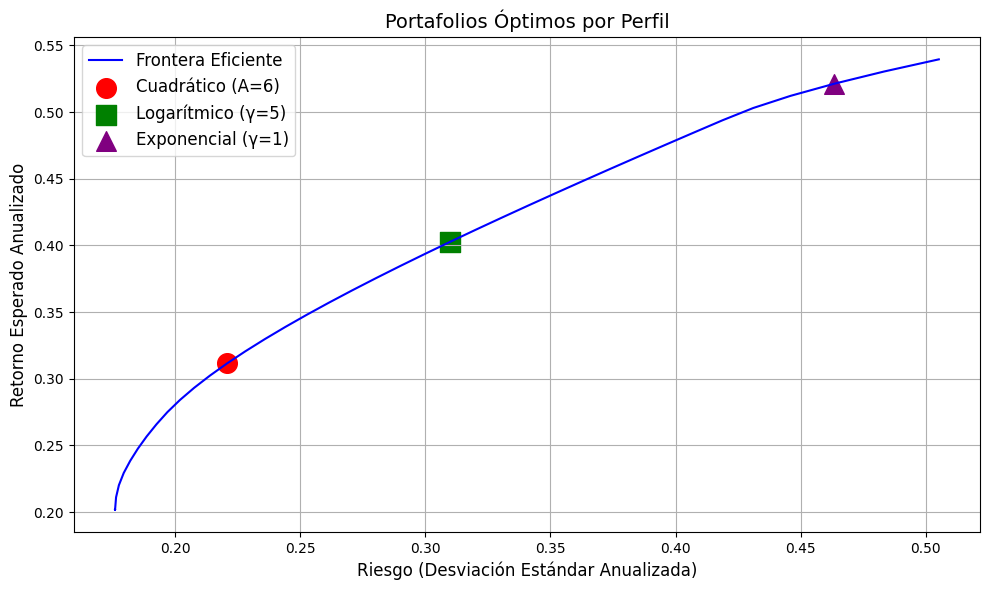

In [ ]:
# Graficar portafolios óptimos en la frontera
plt.figure(figsize=(10, 6))
plt.plot(efficient_df['Riesgo'], efficient_df['Retorno'], 'b-', label='Frontera Eficiente')
plt.scatter(optimo1['Riesgo'], optimo1['Retorno'], s=200, c='red', marker='o', label='Cuadrático (A=6)')
plt.scatter(optimo2['Riesgo'], optimo2['Retorno'], s=200, c='green', marker='s', label='Logarítmico (γ=5)')
plt.scatter(optimo3['Riesgo'], optimo3['Retorno'], s=200, c='purple', marker='^', label='Exponencial (γ=1)')
plt.legend()

plt.title('Portafolios Óptimos por Perfil', fontsize=14)
plt.xlabel('Riesgo (Desviación Estándar Anualizada)', fontsize=12)
plt.ylabel('Retorno Esperado Anualizado', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('portafolios_optimos.png', dpi=300)
plt.show()

In [ ]:
# Mostrar composición de portafolios
def mostrar_pesos(pesos, titulo):
    pesos_series = pd.Series(pesos)
    pesos_series = pesos_series[pesos_series > 0.01]  # Filtrar pesos pequeños
    pesos_series.sort_values(inplace=True)

    plt.figure(figsize=(10, 6))
    pesos_series.plot(kind='barh', color='skyblue')
    plt.title(f'Composición del Portafolio: {titulo}', fontsize=14)
    plt.xlabel('Peso (%)', fontsize=12)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.savefig(f'pesos_{titulo.split(" ")[0].lower()}.png', dpi=300)
    plt.show()


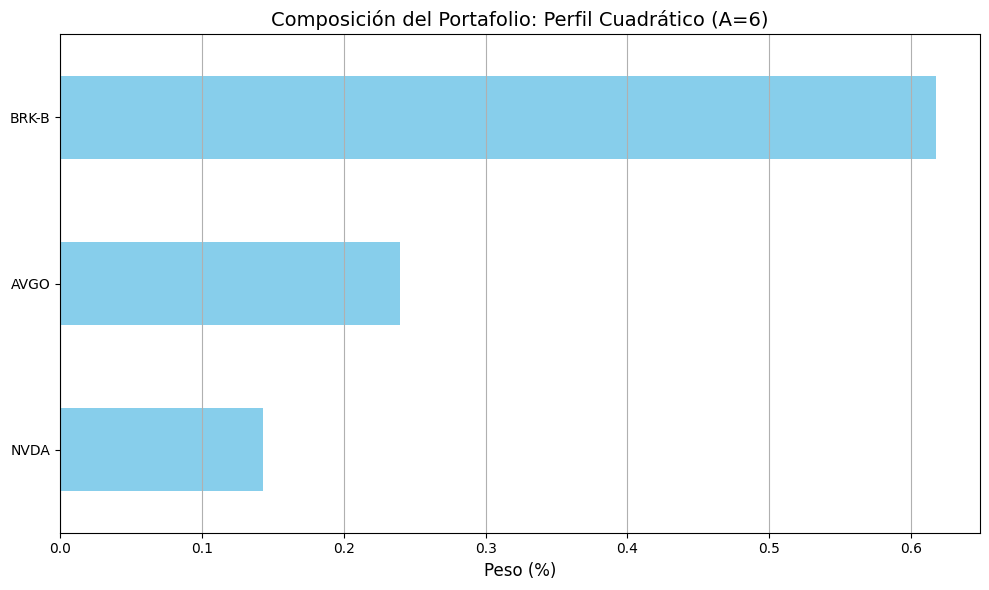

In [ ]:
mostrar_pesos(optimo1['Pesos'], 'Perfil Cuadrático (A=6)')


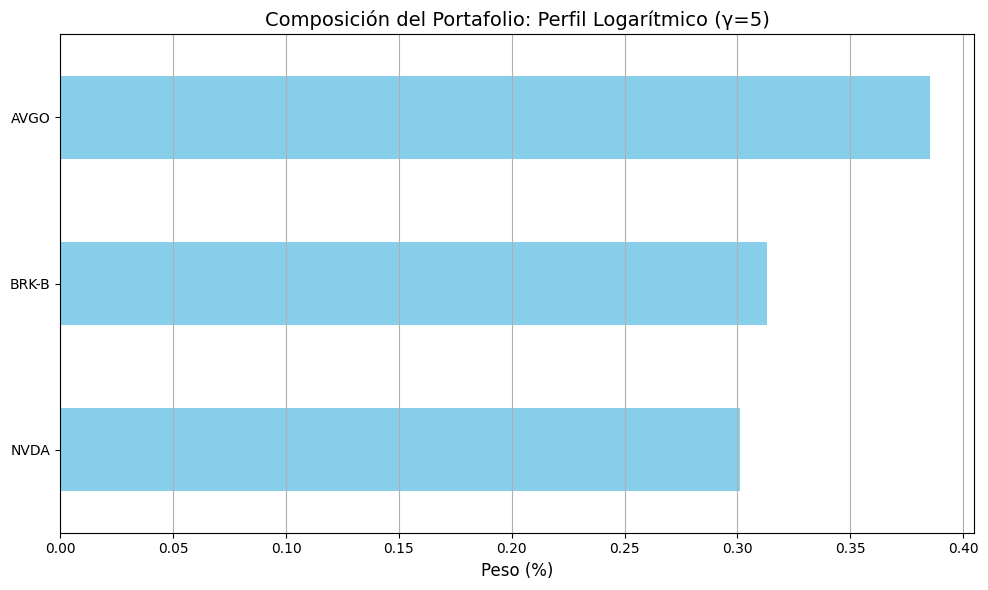

In [ ]:
mostrar_pesos(optimo2['Pesos'], 'Perfil Logarítmico (γ=5)')

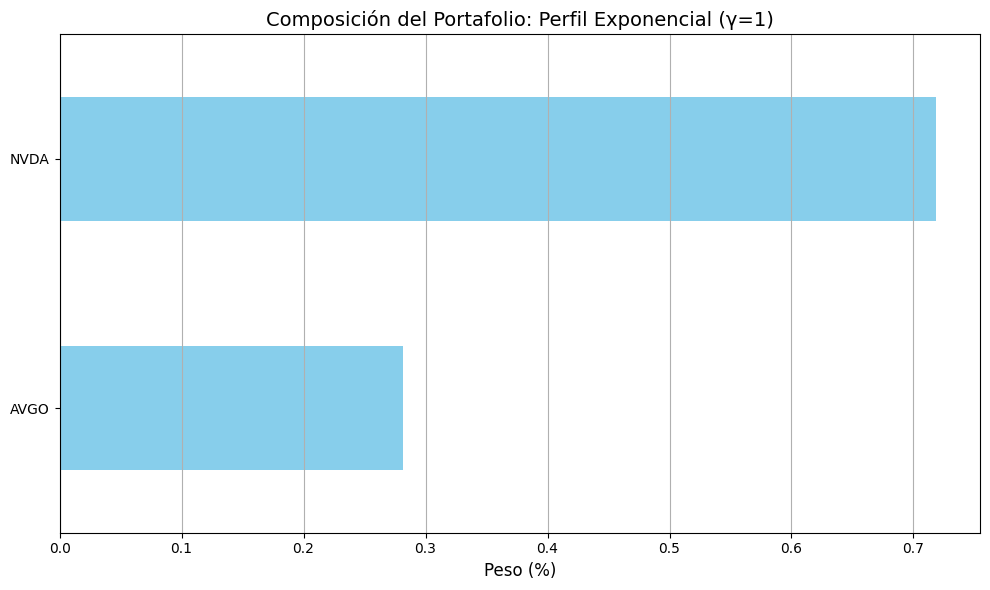

In [ ]:
mostrar_pesos(optimo3['Pesos'], 'Perfil Exponencial (γ=1)')

# 6. Análisis de sensibilidad


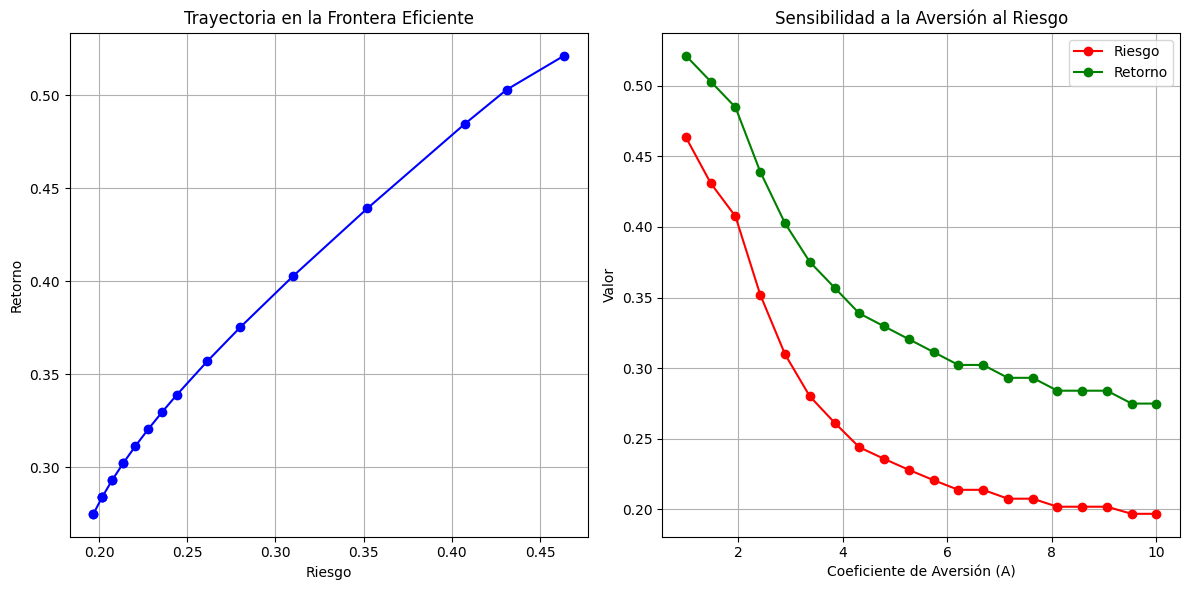

In [ ]:
def analisis_sensibilidad():
    """Analiza cómo cambia el portafolio óptimo con la aversión al riesgo"""
    valores_A = np.linspace(1, 10, 20)
    resultados = []

    for A in valores_A:
        opt = encontrar_optimo(utilidad_cuadratica, A)
        resultados.append({
            'Aversion': A,
            'Retorno': opt['Retorno'],
            'Riesgo': opt['Riesgo']
        })

    resultados_df = pd.DataFrame(resultados)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(resultados_df['Riesgo'], resultados_df['Retorno'], 'bo-')
    plt.title('Trayectoria en la Frontera Eficiente')
    plt.xlabel('Riesgo')
    plt.ylabel('Retorno')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(resultados_df['Aversion'], resultados_df['Riesgo'], 'ro-', label='Riesgo')
    plt.plot(resultados_df['Aversion'], resultados_df['Retorno'], 'go-', label='Retorno')
    plt.title('Sensibilidad a la Aversión al Riesgo')
    plt.xlabel('Coeficiente de Aversión (A)')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('sensibilidad_aversion.png', dpi=300)
    plt.show()

analisis_sensibilidad()

# 7. Código para curvas de indiferencia


In [ ]:
def plot_curvas_indiferencia(retorno_opt, riesgo_opt, funcion_util, parametro, titulo):
    # Crear grid centrado en el punto óptimo
    retornos = np.linspace(retorno_opt - 0.1, retorno_opt + 0.1, 200)
    riesgos = np.linspace(riesgo_opt - 0.1, riesgo_opt + 0.1, 200)
    R, V = np.meshgrid(retornos, riesgos)

    # Calcular utilidad
    U = np.zeros_like(R)
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            U[i, j] = funcion_util(R[i, j], V[i, j], parametro)

    # Calcular utilidad en el punto óptimo
    utilidad_opt = funcion_util(retorno_opt, riesgo_opt, parametro)

    # Crear niveles que incluyan explícitamente la utilidad óptima
    niveles = np.linspace(U.min(), U.max(), 15)
    niveles = np.sort(np.append(niveles, utilidad_opt))  # Añadir nivel óptimo

    plt.figure(figsize=(10, 6))

    # Graficar curvas con nivel óptimo resaltado
    contour = plt.contour(V, R, U, levels=niveles, colors='darkblue', linewidths=1.0)
    plt.contour(V, R, U, levels=[utilidad_opt], colors='red', linewidths=2.5)  # Curva óptima

    plt.clabel(contour, inline=True, fontsize=8)

    #Graficar la frontera Eficiente
    plt.plot(efficient_df['Riesgo'], efficient_df['Retorno'], 'g-', alpha=0.8,
         label='Frontera Eficiente')

    # Marcar punto óptimo
    plt.scatter(riesgo_opt, retorno_opt, s=180, c='red', marker='*',
                edgecolor='black', zorder=5,
                label=f'Óptimo (U={utilidad_opt:.3f})')

    # Configuración adicional
    plt.title(f'Curvas de Indiferencia: {titulo}', fontsize=14)
    plt.xlabel('Riesgo (Desviación Estándar)', fontsize=12)
    plt.ylabel('Retorno Esperado', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    # Añadir texto explicativo
    plt.annotate('Curva de indiferencia que pasa por el punto óptimo',
                 xy=(riesgo_opt, retorno_opt),
                 xytext=(riesgo_opt+0.02, retorno_opt-0.02),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=9)

    plt.tight_layout()
    plt.savefig(f'corregido_{titulo.split(" ")[0].lower()}.png', dpi=300)
    plt.show()



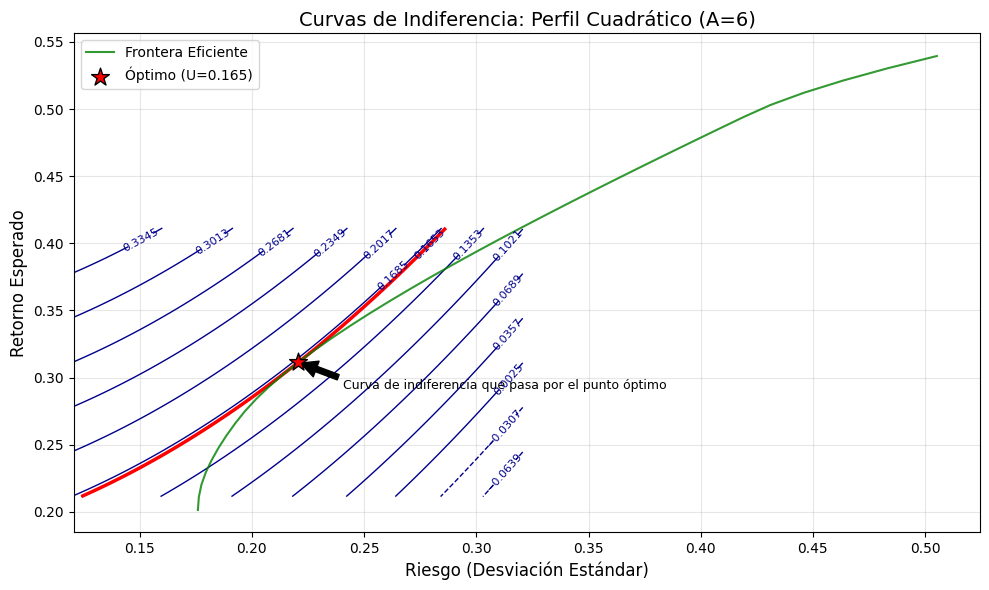

In [ ]:
#@title Curvas de indiferencia para Perfil Cuadratico
plot_curvas_indiferencia(
    optimo1['Retorno'],
    optimo1['Riesgo'],
    utilidad_cuadratica,
    A1,
    'Perfil Cuadrático (A=6)'
)

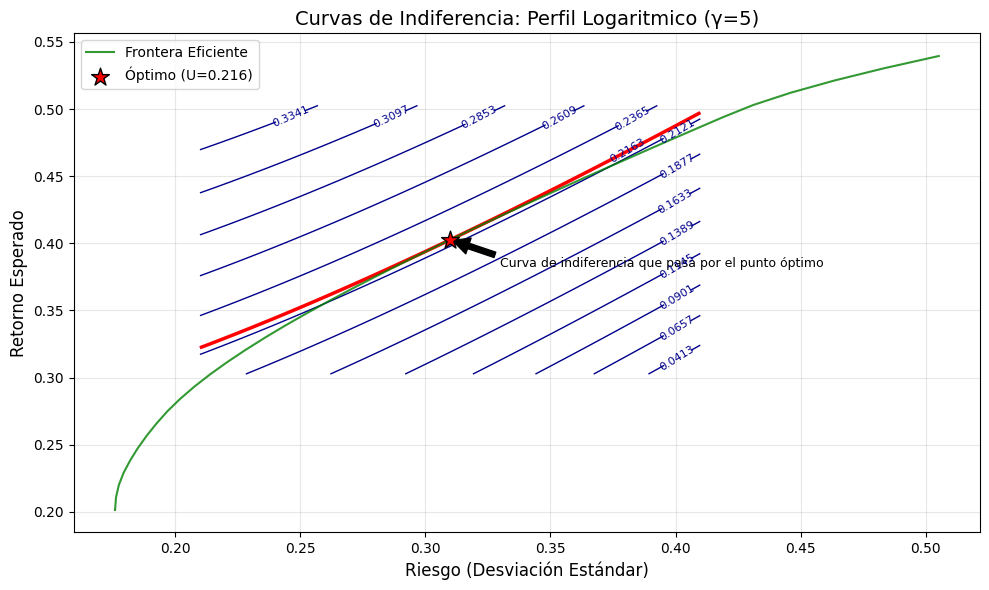

In [ ]:
#@title Curvas de indiferencia Perfil Logaritmico
plot_curvas_indiferencia(
    optimo2['Retorno'],
    optimo2['Riesgo'],
    utilidad_logaritmica,
    gamma2,
    'Perfil Logaritmico (γ=5)'
)

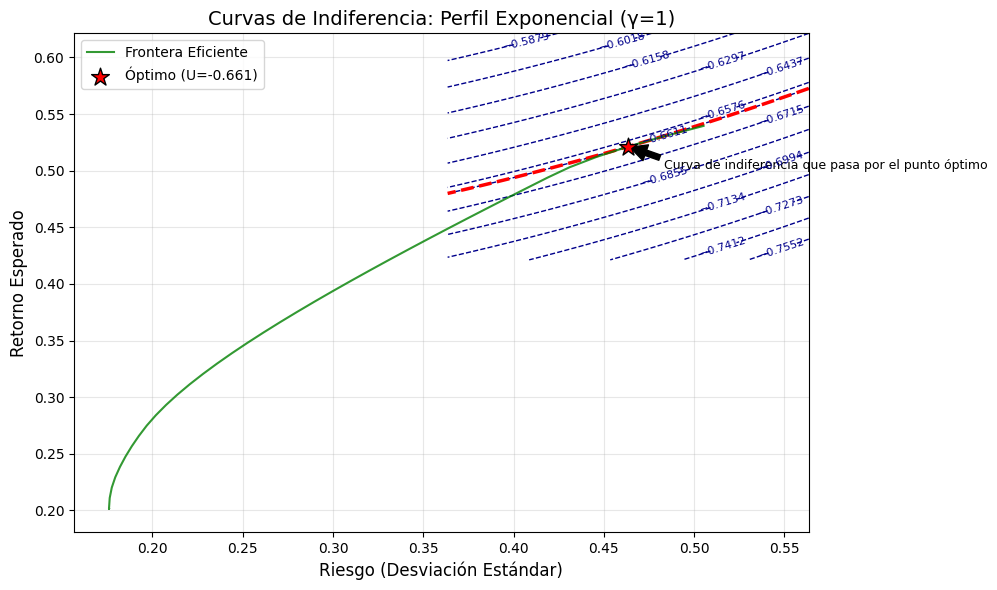

In [ ]:
plot_curvas_indiferencia(
    optimo3['Retorno'],
    optimo3['Riesgo'],
    utilidad_exponencial,
    gamma3,
    'Perfil Exponencial (γ=1)'
)